In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fpdf import FPDF
import textwrap

In [4]:
customers_df = pd.read_csv('../data/Customers.csv')
products_df = pd.read_csv('../data/Products.csv')
transactions_df = pd.read_csv('../data/Transactions.csv')

In [11]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [12]:
sales_data = transactions_df.merge(customers_df, on='CustomerID')
sales_data = sales_data.merge(products_df, on='ProductID')

In [30]:
sales_data.to_csv('../data/sales_data.csv',index=True)

In [13]:
def perform_eda():
    customer_metrics = {
        'total_customers': len(customers_df),
        'customers_by_region': customers_df['Region'].value_counts(),
        'avg_customer_value': sales_data.groupby('CustomerID')['TotalValue'].sum().mean(),
        'customer_lifetime': (sales_data.groupby('CustomerID')['TransactionDate'].max() - 
                            customers_df['SignupDate']).dt.days.mean()
    }
    
    product_metrics = {
        'total_products': len(products_df),
        'sales_by_category': sales_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False),
        'top_products': sales_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10),
        'product_frequency': sales_data.groupby('ProductID')['TransactionID'].count()
    }
    
    sales_metrics = {
        'total_revenue': sales_data['TotalValue'].sum(),
        'avg_transaction_value': sales_data['TotalValue'].mean(),
        'monthly_revenue': sales_data.groupby(sales_data['TransactionDate'].dt.strftime('%Y-%m'))['TotalValue'].sum(),
        'daily_transactions': sales_data.groupby('TransactionDate')['TransactionID'].count()
    }
    
    customer_frequency = sales_data.groupby('CustomerID')['TransactionID'].count()
    retention_metrics = {
        'single_purchase_customers': (customer_frequency == 1).sum(),
        'repeat_customers': (customer_frequency > 1).sum(),
        'avg_purchases_per_customer': customer_frequency.mean(),
        'customer_purchase_gaps': sales_data.groupby('CustomerID')['TransactionDate'].diff().mean()
    }
    
    return customer_metrics, product_metrics, sales_metrics, retention_metrics

In [14]:
def generate_insights():
    customer_metrics, product_metrics, sales_metrics, retention_metrics = perform_eda()
    
    insights = []
    
    # Regional Distribution
    region_contribution = sales_data.groupby('Region')['TotalValue'].sum()
    top_region = region_contribution.idxmax()   
    region_percentage = (region_contribution[top_region] / region_contribution.sum()) * 100
    insights.append(f"Regional Performance: {top_region} leads in sales, contributing {region_percentage:.1f}% of total revenue, indicating strong market presence in this region.")
    
    # Product Category Analysis
    category_sales = sales_data.groupby('Category')['TotalValue'].sum()
    top_category = category_sales.idxmax()
    category_growth = sales_data[sales_data['Category'] == top_category].groupby(
        sales_data['TransactionDate'].dt.strftime('%Y-%m'))['TotalValue'].sum().pct_change().mean() * 100
    insights.append(f"Category Success: {top_category} is the highest-performing category with {category_growth:.1f}% average monthly growth, suggesting strong market demand and potential for expansion.")
    
    # Customer Retention
    repeat_rate = (retention_metrics['repeat_customers'] / 
                  (retention_metrics['single_purchase_customers'] + retention_metrics['repeat_customers'])) * 100
    insights.append(f"Customer Loyalty: {repeat_rate:.1f}% of customers are repeat buyers, with an average of {retention_metrics['avg_purchases_per_customer']:.1f} purchases per customer, indicating strong customer retention.")
    
    # Customer Lifetime Value
    customer_lifetime_value = sales_data.groupby('CustomerID')['TotalValue'].sum().mean()
    top_customers = sales_data.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False)
    top_20_percent = len(top_customers) // 5
    pareto_contribution = (top_customers.head(top_20_percent).sum() / top_customers.sum()) * 100
    insights.append(f"Customer Value Distribution: Average customer lifetime value is ${customer_lifetime_value:.2f}, with top 20% of customers contributing {pareto_contribution:.1f}% of total revenue, suggesting a strong Pareto effect in customer value distribution.")

    # Product Bundle Analysis
    customer_transactions = sales_data.groupby(['CustomerID', 'TransactionID'])['ProductID'].agg(list)
    common_combinations = pd.Series([tuple(sorted(x)) for x in customer_transactions], dtype='object').value_counts()
    if len(common_combinations) > 0:
        top_combo = common_combinations.index[0]
        combo_frequency = common_combinations.iloc[0]
        insights.append(f"Product Bundling Opportunity: Most common product combination purchased together occurred {combo_frequency} times, indicating potential for bundle pricing strategies and cross-selling opportunities.")

    # Customer Acquisition Trends
    monthly_new_customers = customers_df.groupby(customers_df['SignupDate'].dt.strftime('%Y-%m')).size()
    growth_rate = ((monthly_new_customers.iloc[-1] / monthly_new_customers.iloc[0]) - 1) * 100
    insights.append(f"Customer Acquisition: Customer base has shown {growth_rate:.1f}% growth from first to last month, with an average of {monthly_new_customers.mean():.0f} new customers per month.")

    # Purchase Frequency Analysis
    avg_purchase_gap = sales_data.groupby('CustomerID')['TransactionDate'].diff().mean().days
    insights.append(f"Purchase Frequency: Average time between purchases is {avg_purchase_gap:.1f} days, providing a benchmark for customer engagement strategies and identifying potential churn risks.")

    # Price Point Analysis
    price_ranges = pd.qcut(sales_data['Price_x'], q=4, labels=['Budget', 'Mid-low', 'Mid-high', 'Premium'])
    sales_by_price_range = sales_data.groupby(price_ranges)['Quantity'].sum()
    most_popular_range = sales_by_price_range.idxmax()
    range_percentage = (sales_by_price_range[most_popular_range] / sales_by_price_range.sum()) * 100
    insights.append(f"Price Range Performance: {most_popular_range} price range products account for {range_percentage:.1f}% of unit sales, indicating optimal price positioning and consumer preference.")

    # Seasonal Product Performance
    seasonal_category_sales = sales_data.groupby([sales_data['TransactionDate'].dt.month, 'Category'])['TotalValue'].sum().unstack()
    category_seasonality = seasonal_category_sales.idxmax()
    insights.append(f"Seasonal Category Trends: Different product categories show distinct seasonal peaks, with optimal inventory planning opportunities across seasons.")

    # Transaction Size Analysis
    avg_items_per_transaction = sales_data.groupby('TransactionID')['Quantity'].sum().mean()
    large_transactions = (sales_data.groupby('TransactionID')['Quantity'].sum() > avg_items_per_transaction).mean() * 100
    insights.append(f"Transaction Composition: Average transaction contains {avg_items_per_transaction:.1f} items, with {large_transactions:.1f}% of transactions above average, indicating opportunities for basket size optimization.")
    
    return insights



In [15]:
def plot_key_metrics():
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Monthly Revenue Trend
    plt.subplot(3, 2, 1)
    monthly_revenue = sales_data.groupby(sales_data['TransactionDate'].dt.strftime('%Y-%m'))['TotalValue'].sum()
    monthly_revenue.plot(kind='line')
    plt.title('Monthly Revenue Trend')
    plt.xticks(rotation=45)
    
    # Plot 2: Category Distribution
    plt.subplot(3, 2, 2)
    sales_data.groupby('Category')['TotalValue'].sum().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Sales Distribution by Category')
    
    # Plot 3: Regional Performance
    plt.subplot(3, 2, 3)
    sns.barplot(data=sales_data, x='Region', y='TotalValue', estimator=sum)
    plt.title('Total Sales by Region')
    plt.xticks(rotation=45)
    
    # Plot 4: Customer Purchase Frequency
    plt.subplot(3, 2, 4)
    purchase_frequency = sales_data.groupby('CustomerID')['TransactionID'].count().value_counts()
    purchase_frequency.plot(kind='bar')
    plt.title('Customer Purchase Frequency Distribution')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    
    # Plot 5: New Customer Acquisition Trend
    plt.subplot(3, 2, 5)
    customers_df.groupby(customers_df['SignupDate'].dt.strftime('%Y-%m')).size().plot(kind='line')
    plt.title('New Customer Acquisition Trend')
    plt.xticks(rotation=45)
    
    # Plot 6: Average Transaction Value by Region
    plt.subplot(3, 2, 6)
    sns.boxplot(data=sales_data, x='Region', y='TotalValue')
    plt.title('Transaction Value Distribution by Region')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    


In [16]:
def count_words(text):
    return len(text.split())

def create_pdf_report(insights):
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 15)
            self.cell(0, 10, 'Business Analytics Report', 0, 1, 'C')
            self.ln(10)

    pdf = PDF()
    pdf.add_page()
    
    pdf.set_font('Times', '', 10)
    pdf.cell(0, 10, f'Report Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 0, 1, 'R')
    pdf.ln(10)

    pdf.set_font('Times', 'B', 12)
    pdf.cell(0, 10, 'Key Business Insights:', 0, 1, 'L')
    pdf.ln(5)
    
    pdf.set_font('Times', '', 11)
    
    total_words = sum(count_words(insight) for insight in insights)
    pdf.ln(5)
    pdf.set_font('Times', 'B', 11)
    pdf.cell(0, 10, f'Total Word Count: {total_words} words', 0, 1, 'L')
    
    pdf.output('business_analytics_report.pdf')

C:\Users\subha\AppData\Local\Temp\ipykernel_5360\2721970105.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_price_range = sales_data.groupby(price_ranges)['Quantity'].sum()


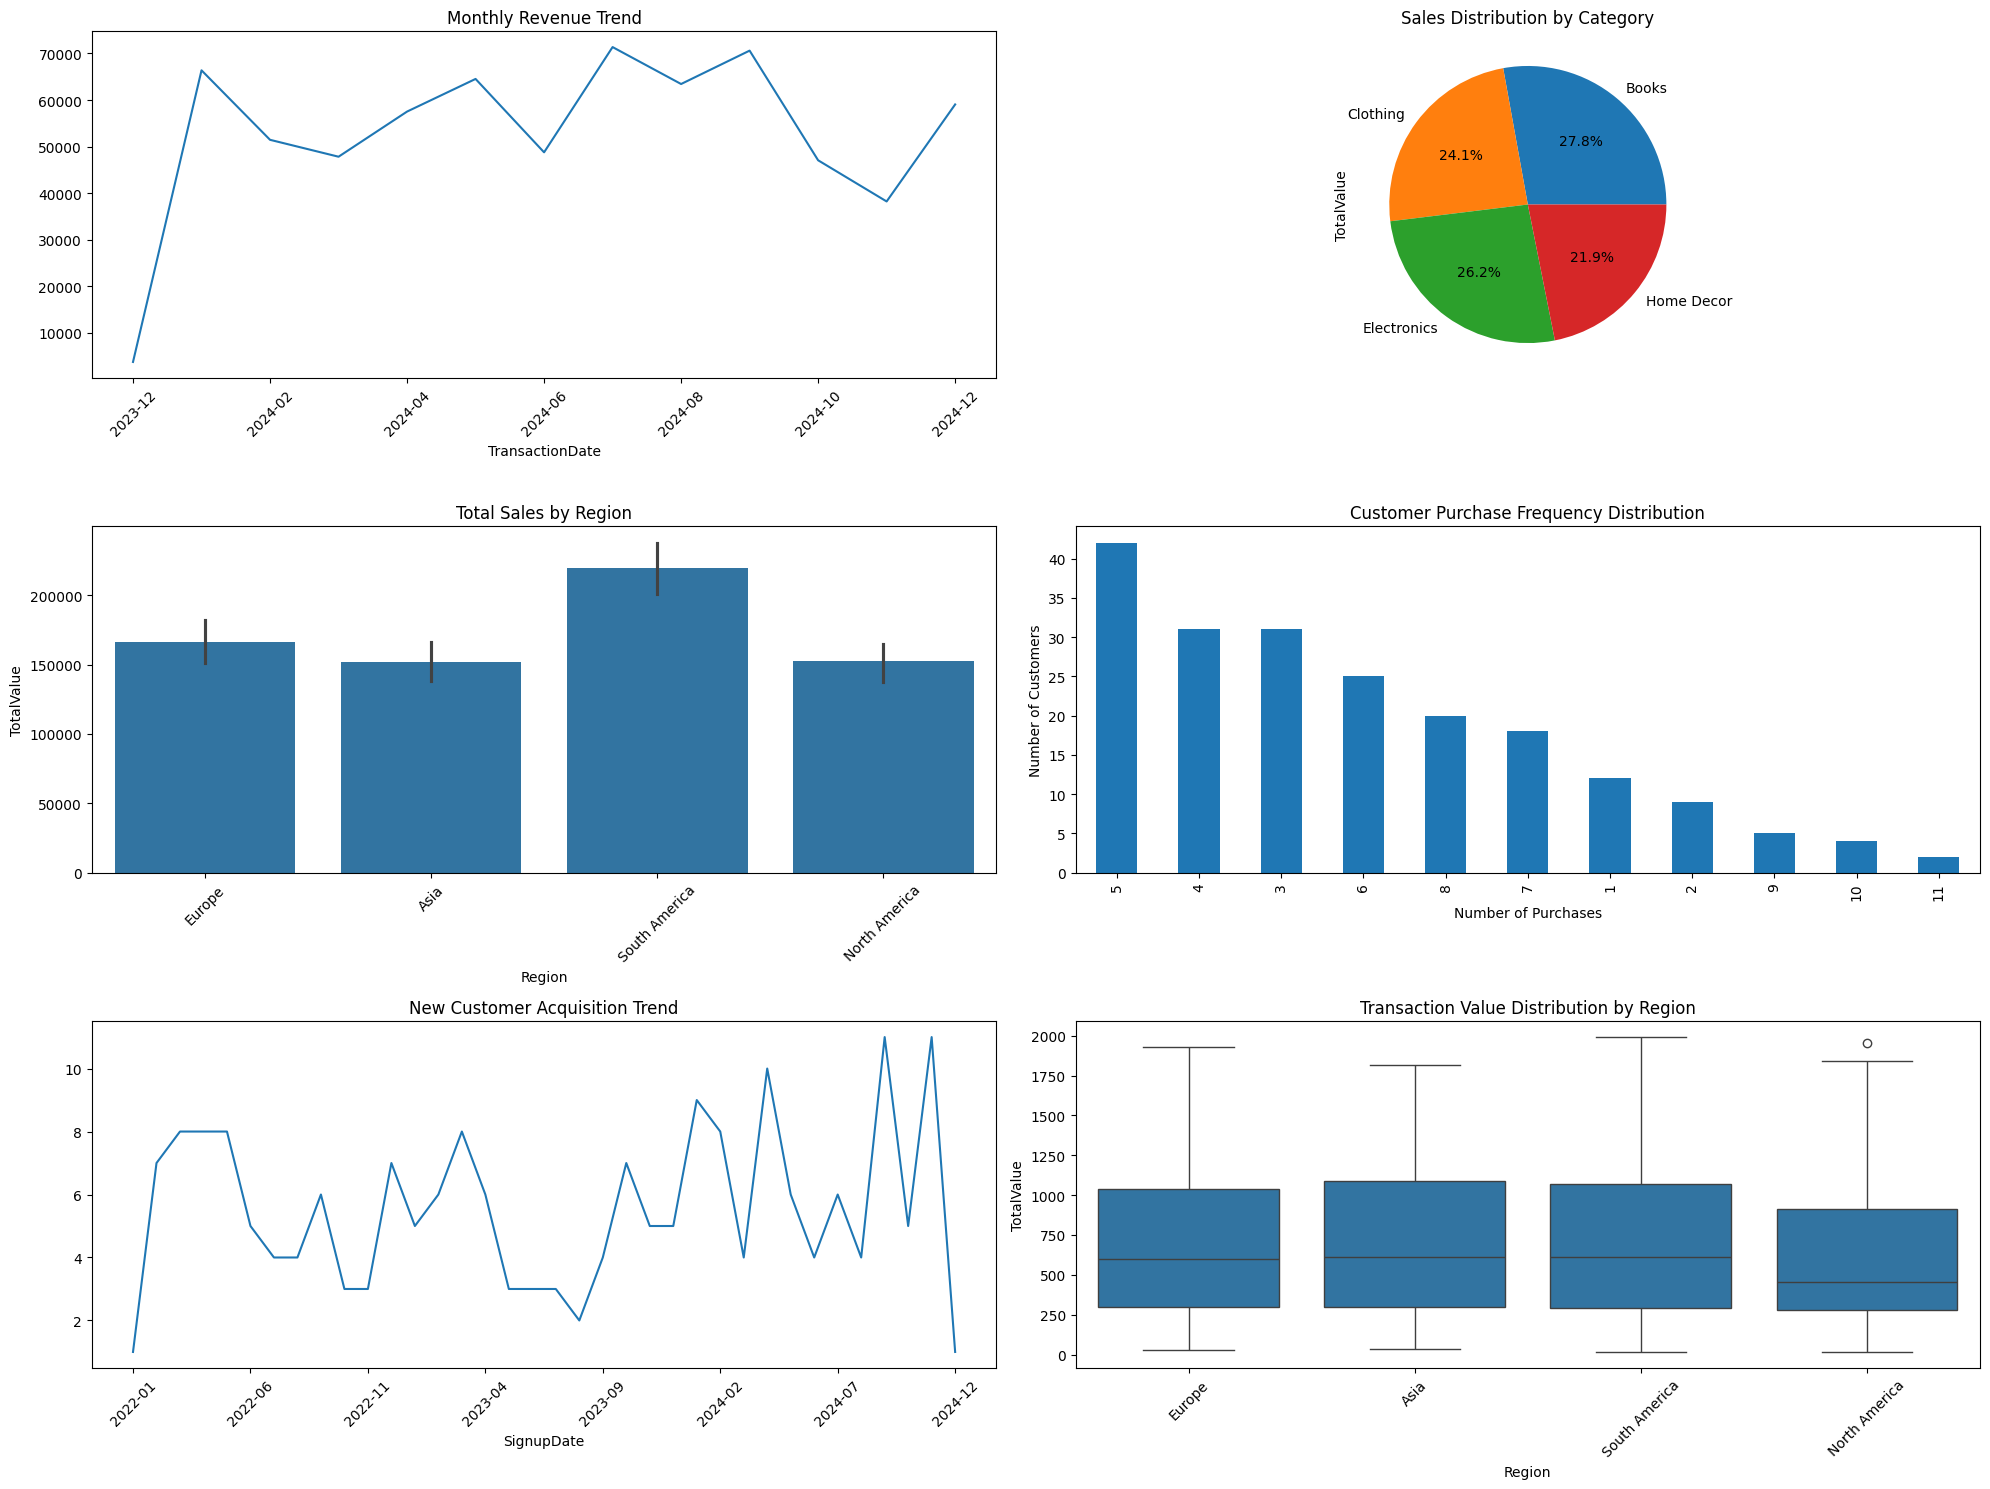


Insights with Word Counts:

Insight 1 (19 words):
Regional Performance: South America leads in sales, contributing 31.8% of total revenue, indicating strong market presence in this region.

Insight 2 (20 words):
Category Success: Books is the highest-performing category with 8.4% average monthly growth, suggesting strong market demand and potential for expansion.

Insight 3 (20 words):
Customer Loyalty: 94.0% of customers are repeat buyers, with an average of 5.0 purchases per customer, indicating strong customer retention.

Insight 4 (28 words):
Customer Value Distribution: Average customer lifetime value is $3467.31, with top 20% of customers contributing 35.1% of total revenue, suggesting a strong Pareto effect in customer value distribution.

Insight 5 (21 words):
Product Bundling Opportunity: Most common product combination purchased together occurred 19 times, indicating potential for bundle pricing strategies and cross-selling opportunities.

Insight 6 (22 words):
Customer Acqu

In [21]:
def count_words(text):
    return len(text.split())

def create_pdf_report(insights):
    class PDF(FPDF):
        def header(self):
            self.set_font('Arial', 'B', 15)
            self.cell(0, 10, 'Business Analytics Report', 0, 1, 'C')
            self.ln(10)

    pdf = PDF()
    pdf.add_page()
    
    pdf.set_font('Times', '', 10)
    pdf.cell(0, 10, f'Report Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 0, 1, 'R')
    pdf.ln(10)

    pdf.set_font('Times', 'B', 12)
    pdf.cell(0, 10, 'Key Business Insights:', 0, 1, 'L')
    pdf.ln(5)
    
    pdf.set_font('Times', '', 11)
    for i, insight in enumerate(insights, 1):
        word_count = count_words(insight)
        
        wrapped_text = textwrap.fill(insight, width=95)
        pdf.multi_cell(0, 10, f'Insight {i} ({word_count} words):', 0, 1)
        pdf.multi_cell(0, 7, wrapped_text, 0, 1)
        pdf.ln(5)
    
    total_words = sum(count_words(insight) for insight in insights)
    pdf.ln(5)
    
    # Save the PDF
    pdf.output('../outputs/subhadip_mondal_eda.pdf')

def main():
    insights = generate_insights()
    plot_key_metrics()
    
    print("\nInsights with Word Counts:")
    total_words = 0
    for i, insight in enumerate(insights, 1):
        word_count = count_words(insight)
        total_words += word_count
        print(f"\nInsight {i} ({word_count} words):")
        print(insight)
    
    print(f"\nTotal Word Count: {total_words} words")
    create_pdf_report(insights)
    print("\nPDF report has been generated as 'outputs/subhadip_mondal_eda.pdf'")

if __name__ == "__main__":
    main()